In [1]:
from functools import reduce
import scipy
from copy import deepcopy
from pauli_channel_approximation import control_unitaries, error_unitary, off_diagonal_projection, adjoint
from GRAPE import control_unitaries
from scipy.linalg import logm
import numpy as np


In [206]:
# Also if it's just the case that one control is as good as the rest,
# OR the convex solver doesn't resolve to enough tolerance, then the optimal control won't really do any better.

In [207]:
import dill 
"""
These pkl files contain PCA objects that define the Hamiltonian, 
the controls that were generated, the standard deviation of the controls
used in the robust optimization, etc
"""
pcas = ["pickled_controls228.pkl",
        "pickled_controls245.pkl",
        "pickled_controls261.pkl",
        "pickled_controls268.pkl",
        "pickled_controls271.pkl"]
# pca228 = dill.load(open(pcas[0], 'rb')) # SQRTY 
# pca245 = dill.load(open(pcas[1], 'rb')) # SQRTX
# pca261 = dill.load(open(pcas[2], 'rb')) # SQRT(ZZ)
choice = 4
num_keep = 100
pca = dill.load(open('../../../randomized_controls/' + pcas[choice], 'rb'))
pca.controlset = pca.controlset[:num_keep]

In [208]:
from scipy.misc import derivative
import numpy as np
from itertools import product

def error(combo, controls, target_operator, control_hamiltonians, ambient_hamiltonian0, dt):
    adjoint_target = np.conj(target_operator.T)
    newcontrols = deepcopy(controls)
    ambient_hamiltonian = [deepcopy(ah).astype("float") for ah in ambient_hamiltonian0]
    for cnum, value in enumerate(combo):
        cnum -= len(ambient_hamiltonian0)
        if cnum >= 0:
            newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
        if cnum < 0:
            ambient_hamiltonian[cnum] *= float(value)
    controls = newcontrols
    #print(newcontrols)
    step_unitaries = control_unitaries(ambient_hamiltonian,
                                       control_hamiltonians, newcontrols,
                                       dt)
    unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
    error_gen = logm(adjoint_target.dot(unitary))
    return -1.j * error_gen


def deg_deriv(controlset, target, control_hamiltonians, ambient_hamiltonian0, dt, deg):
    ds = []
    for control in controlset:
        d = compute_ith_derivative(lambda x:error(x,control, target, control_hamiltonians, ambient_hamiltonian0, dt) , np.array([0,0,0]), tuple(), deg, 4)
        ds.append(d)
    ds = np.array(ds)
    shape = ds.shape
    ds = ds.reshape(-1, 4)
    for i in range(ds.shape[0]):
        ds[i, :] = np.reshape(np.real(proj(ds[i,:].reshape(2,2))), (1,4))
    ds = ds.reshape(*shape)
    return ds

def all_derivs(controlset, target, control_hamiltonians, ambient_hamiltonian0, dt, i):
    res = []
    for deg in range(i+1):
        ds = deg_deriv(controlset, target, control_hamiltonians, ambient_hamiltonian0, dt, deg)
        res.append(ds.astype('float'))
    return res

def partial(func, point, index, args):
    f = lambda x: func([p if i!=index else x for i,p in enumerate(point)])
    return derivative(f, point[index], n=1, args=args)

def compute_partial(f, point, tup, args):
    """Compute the derivative of f at point of order tup, order must be positive"""
    if len(tup) == 1:
        return partial(f, point, tup[0], args)
    # I think this assumes everything is at 0
    return compute_partial(lambda x: partial(f, x, tup[0], args), point, tup[1:], args)  

def compute_ith_derivative(f, point, args, i, matsize):
    if i == 0:
        return np.array(f(point, *args)).flatten().reshape(1, -1)
    indices = list(range(len(point)))
    tups = product(*[indices]*i)
    res = np.zeros(tuple([len(point)]*i+[matsize]), dtype='complex')
    for tup in tups:
        res[tup] = compute_partial(f, point, tup, args).flatten()
    return res

In [209]:
example = lambda x:2*x[0]**2+x[1] + x[0]*x[1]
compute_partial(example, np.array([0, 0]), [0, 0, 1], tuple())

0.0

In [210]:
compute_ith_derivative(example, np.array([0, 0]), tuple(), 0, 1)

array([[0]])

In [211]:
# It appears that requiring equality of higher degrees to zero is too hard/infeasible.

In [212]:
from qutip import sigmax, sigmay, sigmaz
import numpy as np
ps = [np.eye(2), sigmax().data.toarray(), sigmay().data.toarray(), sigmaz().data.toarray()]
ps = [p/np.sqrt(2) for p in ps]
def hs(a, b):
    return np.trace(np.conj(a.T).dot(b))
for p in ps:
    assert np.isclose(hs(p, p), 1)
def proj(h):
    return [np.real(hs(p, h)) for p in ps]

In [213]:
derivs = all_derivs(pca.controlset, pca.target_operator, pca.control_hamiltonians, pca.ambient_hamiltonian, pca.dt, 1)

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


In [233]:
tol = 1E-10

In [303]:
import cvxpy as cp
import numpy as np

def optimal_weights(derivs):
    scalar = 1
    ham_consts = []
    for deriv in derivs:
        ham_consts.append(scalar * np.matrix([d.flatten() for d in deriv]).T)
    omega = cp.Variable(len(derivs[0]))
    constraints = [0 <= omega, omega <= 1, sum(omega)==1]
    # For some reason, the results get better if we include the thing we're minimizing in the equality constraint.
    # In addition, I think the equality isn't being enforced strictly enough.
    if len(ham_consts) != 1:
        equalities = ham_consts[:-1]
    else:
        equalities = ham_consts    
#     equalities = ham_consts[:-1]
    for ham_const in equalities:
        constraints += [ham_const*omega == 0]
    objective = cp.Minimize(cp.norm(ham_consts[-1]*omega))
    prob = cp.Problem(objective, constraints)
    result = prob.solve(abstol=tol, abstol_inacc=tol)
    return omega.value

In [315]:
weights = optimal_weights(derivs)
zeroth = np.matrix([d.flatten() for d in derivs[0]]).T
oneth = np.matrix([d.flatten() for d in derivs[1]]).T
print(scipy.linalg.norm(zeroth.dot(weights)))
print(zeroth.dot(weights))
print(scipy.linalg.norm(oneth.dot(weights)))

5.074936385793711e-15
[[-2.33176891e-15]
 [ 7.34280476e-16]
 [-3.55190409e-15]
 [-2.67631137e-15]]
0.9341475855769473


In [314]:
weights = optimal_weights(derivs[:1])
zeroth = np.matrix([d.flatten() for d in derivs[0]]).T
oneth = np.matrix([d.flatten() for d in derivs[1]]).T
print(scipy.linalg.norm(zeroth.dot(weights)))
print(zeroth.dot(weights))
print(scipy.linalg.norm(oneth.dot(weights)))

2.2213072750347906e-16
[[-2.22044605e-16]
 [ 3.03576608e-18]
 [ 4.33680869e-18]
 [-3.19839641e-18]]
1.0590618204046613


# Plotting utils

In [306]:
def oned_off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt
    %matplotlib inline 


    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = list(zip(values, [0 for _ in values]))
    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()

    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure
    
    for i, row in enumerate(projs[:-1, :]):
        plt.plot(range(len(row)), row)
    plt.plot(range(len(projs[-1, :])), projs[-1, :], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.axvline((num_points-1)/2)
    plt.subplot(212)  # the second subplot in the first figure
    
    for i, row in enumerate(fidelities[:-1, :]):
        plt.plot(range(len(row)), -np.log(1 - row))
    plt.plot(range(len(fidelities[-1, :])), -np.log(1 - fidelities[-1, :]), label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()


In [307]:
def off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt
    %matplotlib inline 


    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = itertools.product(*values_to_plot)
    new_combinations = []
    for combo in combinations:
        new_combo = []
        for index in corr:
            new_combo.append(combo[index])
        new_combinations.append(new_combo)
    combinations = new_combinations

    tuple_length = len(combinations[0])
    standard_ordering = list(range(tuple_length))
    ordering = standard_ordering
    indices = generate_indices(len(values), ordering)

    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()

    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure

    for i, row in enumerate(projs[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), reordered_row)
    plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.subplot(212)  # the second subplot in the first figure
    for i, row in enumerate(fidelities[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), -np.log(1 - reordered_row))
    plt.plot(range(len(fidelities[-1, :])), [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()


In [308]:
num_points = 31
num_processors = 4

# We zoom out with the scale, because the controls were just relatively flat before. There wasn't much to gain locally. Or something like that. But, for instance, going from .1 -> .5 looses information around the peak.

In [309]:
import matplotlib.pyplot as plt

DOING COMBO (-0.00025, 0)
DOING COMBO (-0.00021666666666666666, 0)
DOING COMBO (-0.00018333333333333334, 0)
DOING COMBO (-0.00015000000000000001, 0)
DOING COMBO (-0.00023333333333333333, 0)
DOING COMBO (-0.0002, 0)
DOING COMBO (-0.00013333333333333334, 0)
DOING COMBO (-0.00016666666666666666, 0)
DOING COMBO (-0.00011666666666666667, 0)
DOING COMBO (-8.333333333333332e-05, 0)
DOING COMBO (-4.9999999999999996e-05, 0)
DOING COMBO (-1.6666666666666674e-05, 0)
DOING COMBO (-9.999999999999999e-05, 0)
DOING COMBO (-6.666666666666667e-05, 0)
DOING COMBO (-3.333333333333332e-05, 0)
DOING COMBO (0.0, 0)
DOING COMBO (1.6666666666666674e-05, 0)
DOING COMBO (5.000000000000002e-05, 0)
DOING COMBO (8.333333333333337e-05, 0)
DOING COMBO (3.333333333333335e-05, 0)
DOING COMBO (0.00011666666666666667, 0)
DOING COMBO (6.66666666666667e-05, 0)
DOING COMBO (9.999999999999999e-05, 0)
DOING COMBO (0.00015000000000000001, 0)
DOING COMBO (0.00013333333333333334, 0)
DOING COMBO (0.00018333333333333336, 0)
DOING

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


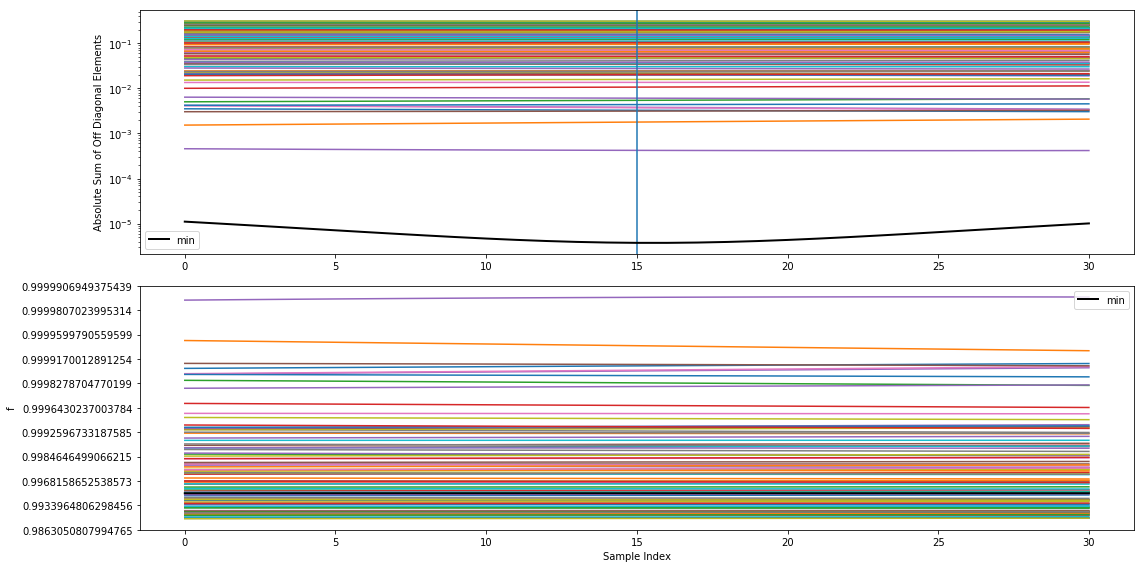

In [310]:
scale = 4
weights = optimal_weights(derivs[:1])
pca = dill.load(open('../../../randomized_controls/' + pcas[choice], 'rb'))
pca.probs = list(np.array(weights).flatten())
pca.controlset = pca.controlset[:num_keep]
oned_off_diagonals(pca, scale)


DOING COMBO (-0.00025, 0)
DOING COMBO (-0.00021666666666666666, 0)
DOING COMBO (-0.00018333333333333334, 0)
DOING COMBO (-0.00015000000000000001, 0)
DOING COMBO (-0.00023333333333333333, 0)
DOING COMBO (-0.0002, 0)
DOING COMBO (-0.00013333333333333334, 0)
DOING COMBO (-0.00016666666666666666, 0)
DOING COMBO (-0.00011666666666666667, 0)
DOING COMBO (-8.333333333333332e-05, 0)
DOING COMBO (-4.9999999999999996e-05, 0)
DOING COMBO (-1.6666666666666674e-05, 0)
DOING COMBO (-9.999999999999999e-05, 0)
DOING COMBO (-6.666666666666667e-05, 0)
DOING COMBO (-3.333333333333332e-05, 0)
DOING COMBO (0.0, 0)
DOING COMBO (1.6666666666666674e-05, 0)
DOING COMBO (5.000000000000002e-05, 0)
DOING COMBO (8.333333333333337e-05, 0)
DOING COMBO (0.00011666666666666667, 0)
DOING COMBO (3.333333333333335e-05, 0)
DOING COMBO (9.999999999999999e-05, 0)
DOING COMBO (6.66666666666667e-05, 0)
DOING COMBO (0.00013333333333333334, 0)
DOING COMBO (0.00015000000000000001, 0)
DOING COMBO (0.00018333333333333336, 0)
DOING

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


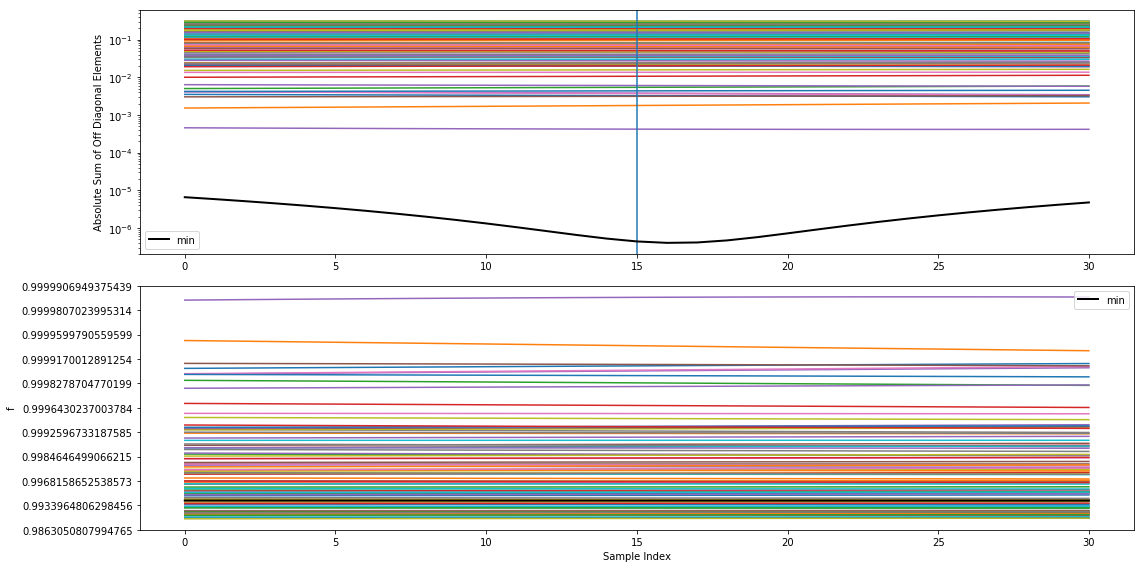

In [311]:
weights = optimal_weights(derivs)
pca = dill.load(open('../../../randomized_controls/' + pcas[choice], 'rb'))
pca.probs = list(np.array(weights).flatten())
pca.controlset = pca.controlset[:num_keep]
oned_off_diagonals(pca, scale)


In [129]:
from pauli_channel_approximation import control_unitaries, error_unitary, off_diagonal_projection, adjoint
import sys
import itertools
from itertools import product
import multiprocessing 
from copy import deepcopy
from functools import reduce

from diamond import diamond_norm, jamiolkowski



def superoperator(unitary):

    return np.kron(unitary.conj(), unitary)



def choi_form(unitary):

    return jamiolkowski(superoperator(unitary))


def diamond_distance(unitary_a,unitary_b):

    return diamond_norm(choi_form(unitary_a) - choi_form(unitary_b))/2.

def compute_diamond_norm(data):
    controlset, ambient_hamiltonian0, combo, dt, control_hamiltonians, target_operator, probs = data
    print("DOING COMBO {}".format(combo))
    sys.stdout.flush()
    fidelities = []
    projs = []
    sops = []
    controlset_unitaries = []
    d_norms = []
    #
    #
    # for i, com in enumerate(combo):
    #     if i != 0 and com != 0:
    #         return 0
    for controls in controlset:
        newcontrols = deepcopy(controls)
        ambient_hamiltonian = [deepcopy(ah).astype("float") for ah in ambient_hamiltonian0]
        for cnum, value in enumerate(combo):
            cnum -= len(ambient_hamiltonian0)
            if cnum >= 0:
                newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
            if cnum < 0:
                ambient_hamiltonian[cnum] *= float(value)
        step_unitaries = control_unitaries(ambient_hamiltonian,
                                           control_hamiltonians, newcontrols,
                                           dt)
        unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
        sop = error_unitary(unitary, target_operator)
        sops.append(sop)
        d_norms.append(diamond_distance(sop, np.eye(sop.shape[0])))
    avg_sop = reduce(lambda a, b: a + b, [prob * sops[i] for i, prob in enumerate(probs)])
    d_norms.append(diamond_distance(avg_sop, np.eye(avg_sop.shape[0])))

    return d_norms

def generate_indices(num_points, order_desired):
    num_indices = len(order_desired)
    tuples = product(range(num_points), repeat=num_indices)
    indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
    return indices
def diamond(pca, weights):
    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0], detuning[0], num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = itertools.product(*values_to_plot)
    new_combinations = []
    for combo in combinations:
        new_combo = []
        for index in corr:
            new_combo.append(combo[index])
        new_combinations.append(new_combo)
    combinations = new_combinations

    tuple_length = len(combinations[0])
    standard_ordering = list(range(tuple_length))
    ordering = standard_ordering
    indices = generate_indices(len(values), ordering)

    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    d_norms = pool.map(compute_diamond_norm, lst)
    pool.close()

    # Compute the off diagonals and fidelities.
    d_norms = np.vstack(d_norms).T



    for i, row in enumerate(d_norms[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), reordered_row)
    plt.plot(range(len(d_norms[-1, :])), [d_norms[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Diamond Distance")
    plt.semilogy()
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.show()


In [482]:
num_points = 3
diamond(pca, weights)

DOING COMBO [-0.001, -0.001]
DOING COMBO [-0.001, 0.0]
DOING COMBO [-0.001, 0.001]
DOING COMBO [0.0, -0.001]


Process ForkPoolWorker-288:
Traceback (most recent call last):
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-287:
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-289:
Traceback (most recent call last):
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-129-bf768765fb0a>", line 57, in compute_diamond_norm
    d_norms.append(diamond_distance(sop, np.eye(sop.shape[0])))
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "